In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
import warnings; warnings.filterwarnings("ignore")

In [2]:
# change with your path of data_eurec4a dir
path = '/venus/matteo/data_eurec4a/'

In [3]:
import sys; sys.path.insert(1, path + 'script')
from plotmap import plot_background
import geometry as gm

In [4]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
s = 50      # sigma gaussian filter s = 50 means 150km

In [6]:
# find and open data
wrf_files =  path + 'data/fields/data_surface_day1.nc'
ds_tot = xr.open_dataset(wrf_files, chunks='auto')

In [7]:
# select domain
mask_lon = (ds_tot.XLONG >= minlon) & (ds_tot.XLONG <= maxlon)
mask_lat = (ds_tot.XLAT >= minlat) & (ds_tot.XLAT <= maxlat)
ds = ds_tot.where(mask_lon & mask_lat, drop=True)
del ds_tot

In [8]:
# def lon lat time
lon = ds['XLONG'].values
lat = ds['XLAT'].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()

In [9]:
# daily SST
sst_day = ds['SST'].values*seamask
# compute anomalies 
s = 50
dsst_day = np.zeros(sst_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)*seamask
    dsst_day[t] = sst_day[t] - sst_ave

0


In [10]:
U10_day = ds['U10'].values*seamask
V10_day = ds['V10'].values*seamask

dU10_day = np.zeros(U10_day.shape); dV10_day = np.zeros(U10_day.shape)
for t in range(0,U10_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    U_ave = gm.nan_gaussian_filter(U10_day[t],s)*seamask
    dU10_day[t] = U10_day[t] - U_ave
    U_ave = gm.nan_gaussian_filter(V10_day[t],s)*seamask
    dV10_day[t] = V10_day[t] - U_ave

0


In [11]:
U10_plot = U10_day / (np.sqrt(U10_day**2. + V10_day**2.))
V10_plot = V10_day / (np.sqrt(U10_day**2. + V10_day**2.))

In [13]:
# daily N2
ds_tmp = xr.open_dataset(path + 'data/fields/N2_surface_day1.nc')
N2_day = ds_tmp['N2'][:,0,:sst_day.shape[1],:sst_day.shape[2]].values*seamask

# compute anomalies 
s = 50
dN2_day = np.zeros(N2_day.shape)
for t in range(0,N2_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    N2_ave = gm.nan_gaussian_filter(N2_day[t],s)*seamask
    dN2_day[t] = N2_day[t] - N2_ave
del N2_day

0


In [14]:
# daily T2
t2_day = ds['T2'].values*seamask
# compute anomalies 
s = 50
dt2_day = np.zeros(t2_day.shape)
for t in range(0,t2_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    t2_ave = gm.nan_gaussian_filter(t2_day[t],s)*seamask
    dt2_day[t] = t2_day[t] - t2_ave

0


Text(0.5, 1.0, '(d)')

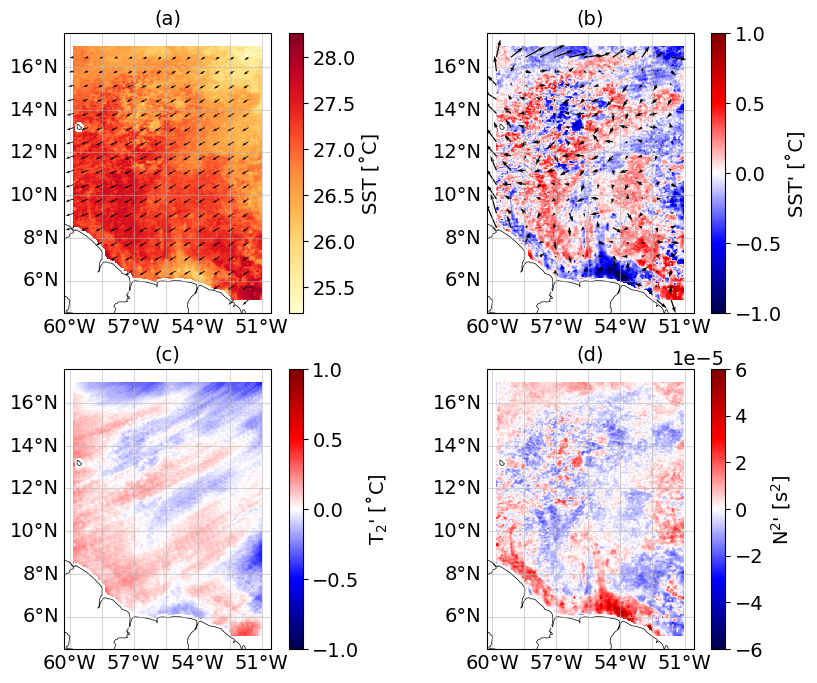

In [15]:
fig = plt.figure(figsize =(10, 8))

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

nt = 0
nskip = 25

ax = plt.subplot(2,2,1, projection=crs)
plot_background(ax)
pcmesh = ax.pcolormesh(lon, lat, sst_day[nt]-273.15, cmap='YlOrRd')
cbar = plt.colorbar(pcmesh); cbar.ax.set_ylabel('SST [˚C]')
ax.quiver(lon[::nskip,::nskip], lat[::nskip,::nskip], U10_day[nt,::nskip,::nskip], V10_day[nt,::nskip,::nskip])
ax.set_title('(a)', fontsize=14)

ax = plt.subplot(2,2,2, projection=crs)
plot_background(ax)
pcmesh = ax.pcolormesh(lon, lat, dsst_day[nt], vmin=-1., vmax=1., cmap='seismic')
cbar = plt.colorbar(pcmesh); cbar.ax.set_ylabel("SST' [˚C]")
ax.quiver(lon[::nskip,::nskip], lat[::nskip,::nskip], dU10_day[nt,::nskip,::nskip], dV10_day[nt,::nskip,::nskip], width=0.006)
ax.set_title('(b)', fontsize=14)

ax = plt.subplot(2,2,3, projection=crs)
plot_background(ax)
pcmesh = ax.pcolormesh(lon, lat, dt2_day[nt], vmin=-1., vmax=1., cmap='seismic')
cbar = plt.colorbar(pcmesh); cbar.ax.set_ylabel("T$_2$' [˚C]")
ax.set_title('(c)', fontsize=14)

ax = plt.subplot(2,2,4, projection=crs)
plot_background(ax)
pcmesh = ax.pcolormesh(lon, lat, dN2_day[nt], vmin=-6.e-5, vmax=6.e-5, cmap='seismic')
cbar = plt.colorbar(pcmesh); cbar.ax.set_ylabel("N$^{2}$' [s$^{2}$]")
ax.set_title('(d)', fontsize=14)

# plt.tight_layout()